# Intelligent Stock News Analysis Agent
*Analyzing NVDA, TSLA, MSFT for news-based movement signals*

## Phase 0: Preparation

### 0.1 Packages Installation and Imports

In [1]:
# Install required packages
!pip install yfinance pandas numpy matplotlib seaborn
!pip install scikit-learn torch transformers
!pip install vaderSentiment textblob
!pip install requests beautifulsoup4
!pip install networkx spacy
!pip install python-dotenv
!python -m spacy download en_core_web_sm

# For Reddit data
!pip install praw

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ------------ --------------------------- 3.9/12.8 MB 21.3 MB/s eta 0:00:01
     ----------------------------- ---------- 9.4/12.8 MB 24.5 MB/s eta 0:00:01
     ------------------------------------- - 12.3/12.8 MB 21.5 MB/s eta 0:00:01
     ------------------------------------- - 12.3/12.8 MB 21.5 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 13.6 MB/s  0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [71]:
# Utils
import os
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from datetime import datetime, timedelta, time

# APIs & Web
import praw
import yfinance as yf

# NLP & Sentiment
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

load_dotenv()

True

### 0.2 API & External Service Setup

In [ ]:
try:
    reddit = praw.Reddit(
        client_id=os.getenv('REDDIT_CLIENT_ID'),
        client_secret=os.getenv('REDDIT_CLIENT_SECRET'), 
        user_agent=os.getenv('REDDIT_USER_AGENT')
    )
    print("✓ Reddit API connected successfully")
except Exception as e:
    print(f"✗ Reddit API failed: {e}")
    reddit = None

### 0.3 Analyzers & Models Setup

In [ ]:
vader_analyzer = SentimentIntensityAnalyzer()
print("✓ Sentiment analyzers initialized")

## Phase 1: Data Collection
### 1.1 Stock Data Collection

In [73]:
# Define stocks and time period
stocks = ['NVDA', 'TSLA', 'MSFT']
end_date = datetime.now()
start_date = end_date - timedelta(days=730)  # 2 years

# Download stock data
print("Downloading stock data...")
stock_data = {}

for ticker in stocks:
    print(f"Fetching {ticker}...")
    stock = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
    stock_data[ticker] = stock
    print(f"  {ticker}: {len(stock)} trading days")

print("\nStock data collection complete!")

Fetching NVDA...


[*********************100%***********************]  1 of 1 completed


  NVDA: 501 trading days
Fetching TSLA...


[*********************100%***********************]  1 of 1 completed


  TSLA: 501 trading days
Fetching MSFT...


[*********************100%***********************]  1 of 1 completed

  MSFT: 501 trading days

Stock data collection complete!


#### 1.1.1 Stock Data Visualization

In [4]:
# Initial Data check
for ticker, data in stock_data.items():
    print(f"\n{ticker} data shape: {data.shape}")
    print(f"Date range: {data.index[0].date()} to {data.index[-1].date()}")
    print(f"Columns: {list(data.columns)}")
    print(data.head(2))


NVDA data shape: (125, 5)
Date range: 2025-04-28 to 2025-10-23
Columns: [('Close', 'NVDA'), ('High', 'NVDA'), ('Low', 'NVDA'), ('Open', 'NVDA'), ('Volume', 'NVDA')]
Price            Close        High         Low        Open     Volume
Ticker            NVDA        NVDA        NVDA        NVDA       NVDA
Date                                                                 
2025-04-28  108.716316  110.356109  106.006651  109.676194  207708500
2025-04-29  109.006279  110.186131  107.426484  107.656450  170444300

TSLA data shape: (125, 5)
Date range: 2025-04-28 to 2025-10-23
Columns: [('Close', 'TSLA'), ('High', 'TSLA'), ('Low', 'TSLA'), ('Open', 'TSLA'), ('Volume', 'TSLA')]
Price            Close        High         Low        Open     Volume
Ticker            TSLA        TSLA        TSLA        TSLA       TSLA
Date                                                                 
2025-04-28  285.880005  294.859985  272.420013  288.980011  151731800
2025-04-29  292.029999  293.320007  27

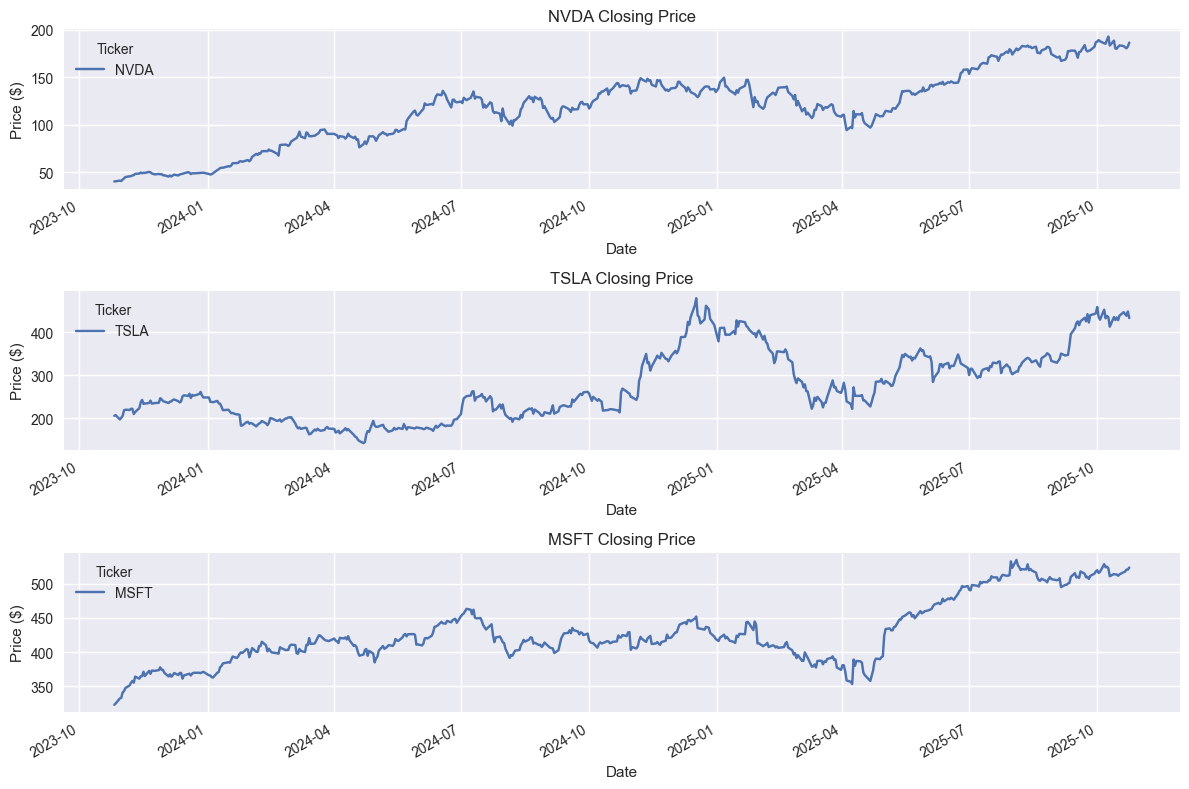

NVDA - Average daily return: 0.36% Volatility: 3.18%
TSLA - Average daily return: 0.23% Volatility: 3.99%
MSFT - Average daily return: 0.11% Volatility: 1.38%


In [74]:
# Plot stock price trends
plt.figure(figsize=(12, 8))
for i, ticker in enumerate(stocks, 1):
    plt.subplot(3, 1, i)
    # Explicitly get the current axis and plot to it
    ax = plt.gca()
    stock_data[ticker]['Close'].plot(ax=ax, title=f'{ticker} Closing Price', grid=True)
    plt.ylabel('Price ($)')
plt.tight_layout()
plt.show()

# Calculate daily returns
returns_data = {}
for ticker in stocks:
    returns = stock_data[ticker][['Close']].pct_change().squeeze()
    returns_data[ticker] = returns
    print(f"{ticker} - Average daily return: {returns.mean():.2%} Volatility: {returns.std():.2%}")

### 1.2 News Data Collection

#### 1.2.1 Prepare Collection

In [78]:
stock_keywords = {
    'NVDA': ['nvidia', 'nvda'],
    'TSLA': ['tesla', 'tsla', 'elon', 'musk'],
    'MSFT': ['microsoft', 'msft', 'satya', 'windows']
}

# Placeholder for news data structure
news_post_data_structure = {
    'source': [], # e.g. Reddit, or BBC
    'category': [], # e.g. subreddit, or news category
    'datetime': [],
    'stock': [],
    'title': [],
    'content': [],
    'score': [],
    'sentiment_score': [],
    'sentiment_label': [],
}

def analyze_sentiment(text):
    """Analyze sentiment using multiple methods"""
    if not text or text == '[removed]' or text == '[deleted]':
        return 0.0, 'neutral'
    
    # VADER sentiment
    vader_scores = vader_analyzer.polarity_scores(text)
    vader_compound = vader_scores['compound']
    
    # TextBlob sentiment
    blob = TextBlob(text)
    textblob_polarity = blob.sentiment.polarity
    
    # Combine both scores
    final_score = (vader_compound + textblob_polarity) / 2
    
    # Categorize
    if final_score > 0.1:
        sentiment_label = 'positive'
    elif final_score < -0.1:
        sentiment_label = 'negative'
    else:
        sentiment_label = 'neutral'
        
    return final_score, sentiment_label

#### 1.2.2 Collect News Data

##### 1.2.2.1 Reddit

In [106]:
def collect_reddit_posts(limit=100):
    """Collect Reddit posts with sentiment analysis"""
    reddit_posts = []
    subreddits = ['wallstreetbets', 'stocks', 'investing', 'StockMarket']
    
    for subreddit_name in subreddits:
        print(f"Collecting from r/{subreddit_name}...")
        try:
            subreddit = reddit.subreddit(subreddit_name)
            
            for post in subreddit.new(limit=limit//len(subreddits)):
                post_date = datetime.fromtimestamp(post.created_utc).date()
                content = (post.title + ' ' + (post.selftext or '')).lower()
                
                # Check for stock mentions
                stock_mentions = []
                
                for stock, keywords in stock_keywords.items():
                    if any(keyword in content for keyword in keywords):
                        stock_mentions.append(stock)
                
                if stock_mentions:
                    sentiment_score, sentiment_label = analyze_sentiment(post.title + ' ' + post.selftext)
                    
                    post_data = {
                        'datetime': datetime.fromtimestamp(post.created_utc),
                        'source': 'Reddit',
                        'category': subreddit_name,
                        'stock': ', '.join(stock_mentions),
                        'title': post.title,
                        'content': post.selftext,
                        'score': post.score,
                        'sentiment_score': sentiment_score,
                        'sentiment_label': sentiment_label,
                    }
                    reddit_posts.append(post_data)
                    
        except Exception as e:
            print(f"Error with r/{subreddit_name}: {e}")
            continue
    
    return reddit_posts

In [107]:
all_news_posts = []

print("Collecting Reddit posts with sentiment analysis...")
reddit_posts = collect_reddit_posts(limit=10000)
all_news_posts.extend(reddit_posts) 
print(f"✓ Collected {len(reddit_posts)} stock-related posts")
print(f"Sentiment distribution:")

news_posts_df = pd.DataFrame(all_news_posts)
news_posts_df = news_posts_df.set_index(['source', 'datetime'], drop=False)
print(news_posts_df['sentiment_label'].value_counts())

✓ Collected 438 stock-related posts
Sentiment distribution:
sentiment_label
positive    312
neutral      69
negative     57
Name: count, dtype: int64


In [110]:
def align_news_posts_with_stocks(posts_df, stock_data):
    """Align post sentiments with stock price movements"""
    aligned_data = []
    
    for ticker in stocks:
        stock_prices = stock_data[ticker]
        
        # Filter posts for this stock
        stock_posts = posts_df[posts_df['stock'].str.contains(ticker, na=False)].copy()
        
        for index, post_row in stock_posts.iterrows():
            post_date = post_row['datetime'].normalize()

            # Find stock price on news day and next day
            if post_date in stock_prices.index:
                current_close = stock_prices.loc[post_date, 'Close'].item()
                
                # Find next trading day
                next_dates = stock_prices[stock_prices.index > post_date]
                if len(next_dates) > 0:
                    next_date = next_dates.index[0]
                    next_close = stock_prices.loc[next_date, 'Close'].item()
                    
                    # Calculate price movement
                    price_change = (next_close - current_close) / current_close
                    price_change_pct = price_change * 100
                    
                    # Determine direction
                    if price_change_pct > 0.5:
                        movement = 'UP'
                    elif price_change_pct < -0.5:
                        movement = 'DOWN'
                    else:
                        movement = 'STABLE'
                    
                    aligned_data.append({
                        'date': post_date,
                        'stock': ticker,
                        'post_sentiment_score': post_row['sentiment_score'],
                        'post_sentiment_label': post_row['sentiment_label'],
                        'post_title': post_row['title'],
                        'post_score': post_row['score'],
                        'current_price': current_close,
                        'next_day_price': next_close,
                        'price_change_pct': price_change_pct,
                        'movement': movement
                    })
    
    return pd.DataFrame(aligned_data)

# Align our news with stock data
print("Aligning news sentiment with stock prices...")
aligned_df = align_news_posts_with_stocks(news_posts_df, stock_data)
print(f"✓ Created {len(aligned_df)} aligned news-price records")
print(f"Price movement distribution:")
print(aligned_df['movement'].value_counts())

Aligning news sentiment with stock prices...
✓ Created 416 aligned news-price records
Price movement distribution:
movement
UP        163
DOWN      160
STABLE     93
Name: count, dtype: int64


=== INITIAL ANALYSIS OF 30 ALIGNED RECORDS ===

1. BASIC STATS:
Total aligned records: 416
Records per stock: {'NVDA': 223, 'TSLA': 119, 'MSFT': 74}
Average sentiment score: 0.280
Average price change: -0.17%

2. SENTIMENT EFFECTIVENESS:
Positive sentiment → UP movement: 118/302 (39.1%)
Negative sentiment → DOWN movement: 17/51 (33.3%)

3. CORRELATION ANALYSIS:
Correlation (sentiment vs price change): -0.023
Interpretation: weak negative correlation


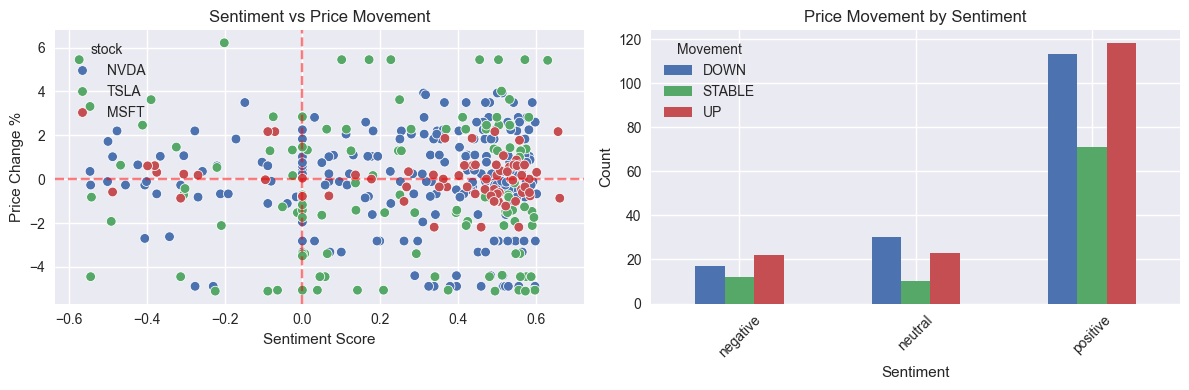


4. SAMPLE PREDICTIONS:
Recent aligned news-price pairs:
      date stock post_sentiment_label  price_change_pct movement
2025-10-23  NVDA             positive          2.250763       UP
2025-10-23  TSLA             positive         -3.398817     DOWN
2025-10-23  NVDA             positive          2.250763       UP
2025-10-23  NVDA             positive          2.250763       UP
2025-10-23  NVDA             positive          2.250763       UP
2025-10-23  NVDA             positive          2.250763       UP
2025-10-23  NVDA             positive          2.250763       UP
2025-10-23  NVDA              neutral          2.250763       UP
2025-10-23  TSLA              neutral         -3.398817     DOWN
2025-10-23  TSLA             positive         -3.398817     DOWN


In [113]:
# Analysis of your successful alignment
print("=== INITIAL ANALYSIS OF 30 ALIGNED RECORDS ===")

# 1. Basic statistics
print(f"\n1. BASIC STATS:")
print(f"Total aligned records: {len(aligned_df)}")
print(f"Records per stock: {aligned_df['stock'].value_counts().to_dict()}")
print(f"Average sentiment score: {aligned_df['post_sentiment_score'].mean():.3f}")
print(f"Average price change: {aligned_df['price_change_pct'].mean():.2f}%")

# 2. Sentiment effectiveness
print(f"\n2. SENTIMENT EFFECTIVENESS:")
positive_correct = len(aligned_df[(aligned_df['post_sentiment_label'] == 'positive') & (aligned_df['movement'] == 'UP')])
positive_total = len(aligned_df[aligned_df['post_sentiment_label'] == 'positive'])
negative_correct = len(aligned_df[(aligned_df['post_sentiment_label'] == 'negative') & (aligned_df['movement'] == 'DOWN')])
negative_total = len(aligned_df[aligned_df['post_sentiment_label'] == 'negative'])

if positive_total > 0:
    print(f"Positive sentiment → UP movement: {positive_correct}/{positive_total} ({positive_correct/positive_total:.1%})")
if negative_total > 0:
    print(f"Negative sentiment → DOWN movement: {negative_correct}/{negative_total} ({negative_correct/negative_total:.1%})")

# 3. Correlation analysis
print(f"\n3. CORRELATION ANALYSIS:")
correlation = aligned_df['post_sentiment_score'].corr(aligned_df['price_change_pct'])
print(f"Correlation (sentiment vs price change): {correlation:.3f}")

# Interpret the correlation
if abs(correlation) > 0.3:
    strength = "strong"
elif abs(correlation) > 0.1:
    strength = "moderate" 
else:
    strength = "weak"
    
direction = "positive" if correlation > 0 else "negative"
print(f"Interpretation: {strength} {direction} correlation")

# 4. Visualize the relationship
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 4))

# Plot 1: Sentiment vs Price Change
plt.subplot(1, 2, 1)
sns.scatterplot(data=aligned_df, x='post_sentiment_score', y='price_change_pct', hue='stock')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='red', linestyle='--', alpha=0.5)
plt.xlabel('Sentiment Score')
plt.ylabel('Price Change %')
plt.title('Sentiment vs Price Movement')

# Plot 2: Movement distribution by sentiment
plt.subplot(1, 2, 2)
movement_by_sentiment = pd.crosstab(aligned_df['post_sentiment_label'], aligned_df['movement'])
movement_by_sentiment.plot(kind='bar', ax=plt.gca())
plt.title('Price Movement by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.legend(title='Movement')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 5. Show some example predictions
print(f"\n4. SAMPLE PREDICTIONS:")
print("Recent aligned news-price pairs:")
sample_data = aligned_df[['date', 'stock', 'post_sentiment_label', 'price_change_pct', 'movement']].sort_values('date', ascending=False).head(10)
print(sample_data.to_string(index=False))